# Field Reversed Configuration (FRC) Simulations

The FRC formed through an RMF can be characterized by two important dimensionless parameters, $\lambda=R/\delta$, where $\delta=(2\eta /\mu_o \omega)^{1/2}$ is the classical skin depth, and by $\gamma=\omega_{ce}/\nu_{ei}$, where $\nu_{ei}=\eta(ne^2/m_e)$ is the electron-ion collision frequency. In term of the system parameters, these two parameters can be expressed as

$$ \lambda = R \left(\frac{\mu_o\omega}{2\eta}\right)^{1/2} $$,

$$ \gamma = \frac{1}{e}\left(\frac{B_\omega}{n\eta}\right) $$.

The magnitude of the external-driving field must exceed a certain critical value before much current is driven in the plasma column.

The measure of the current drive is the parameter $\alpha$, which is defined as the ratio of the driven current divided by the current obtained if all of the electrons rotate synchronously with the RMF.

$$ \alpha = \frac{2}{\mu_o n e \omega R^2}\left(B_z(r=R) - B(r=0) \right) $$

In [1]:
#######  IMPORTS ###########
import os
import re
#import vtk

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#from vtk.util.numpy_support import vtk_to_numpy

# import pandas and seaborn
import pandas as pd
#import seaborn as sns

#import scikit-learn function
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns

No handles with labels found to put in legend.


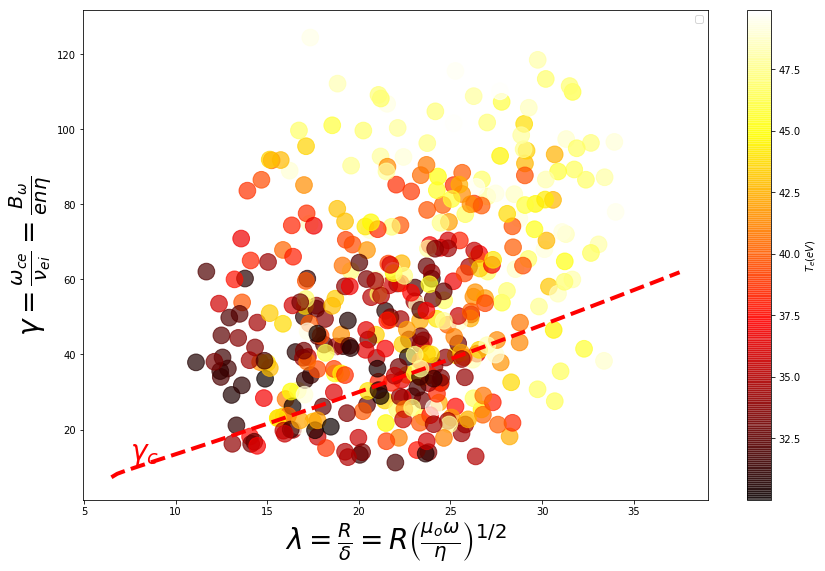

In [2]:
number = 200 # Sample size

def calRatio(w, Bw, Te):
    mu_o = np.pi*4.e-7
    e = 1.602e-19

    n = 1.0e20
    R = 0.03
    loglambda = 10.

    eta = 5.2e-5*loglambda/(Te)**1.5
    #eta = 1.65e-9*loglambda/(Te/1.e3)**1.5

    gamma = Bw/e/n/eta
    lmbda = R*np.sqrt(0.5*mu_o*w/eta)

    return gamma, lmbda

def gammaCritical(lbd):
    return 1.12*lbd*(1.0+0.12*(lbd-6.5)**0.4)

def getSelectionInRange(var, rmin, rmax, sample):
    a = np.where(var>rmin)
    b = np.where(var<rmax)
    intersec = np.intersect1d(a,b)

    if(sample<len(intersec)):
        randSample = np.random.randint(len(intersec), size=sample)
        res = intersec[randSample]
    else:
        res = intersec

    return res

def plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,classifier,scaler,title):
    
    X_set, y_set = X_train, y_train
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Areas = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:,1].reshape(X1.shape)
    
    
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
    X1 = Xit[:,0].reshape(X1.shape)
    X2 = Xit[:,1].reshape(X2.shape)    
    
    plt.figure(figsize=(14,9))
    levels = np.linspace(0.,1.,21)
    sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
    plt.colorbar(sc, label='Probability of Reversal')
    
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    
    ln = ['no_train','yes_train']
    
    X_set = scaler.inverse_transform(X_train)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                    c=ListedColormap(('red','cyan'))(i), s=280, alpha=0.7)
        
    lt = ['no_test','yes_test']
    X_tt = scaler.inverse_transform(X_test)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_tt[y_test==j, 0], X_tt[y_test==j,1],
                    c=ListedColormap(('red','cyan'))(i), s=280, alpha=0.7)
    
    plt.contour(X1,X2,Areas,[0.5],linewidths=4)
    #xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
    xx = np.linspace(6.5,40.,1000)
    plt.plot(xx,gammaCritical(xx),'k--',lw=4.)
    
    plt.title(title)
    plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
    plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
    #plt.legend()


old = np.genfromtxt('frc_post_data.txt')
# Read in the new FRC simulations
new = np.genfromtxt('/home/sousae/frc_data/newFRCdata.txt')
# merge both new and old data
frc = np.concatenate((old,new),axis=0)

plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,2], cmap="hot", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$T_e (eV)$')
plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')
plt.savefig("figure1.png",dpi=300)

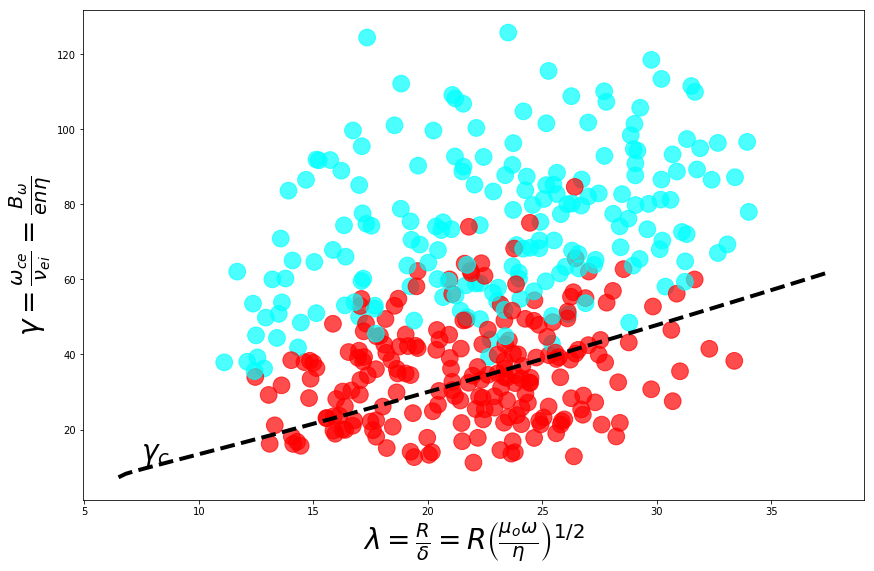

In [3]:
plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,11], cmap=ListedColormap(('red', 'cyan')), alpha=0.7,s=280)

#cb = plt.colorbar(sc, label=r'$B_z Reversal$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'k--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='black')
plt.savefig("figure2.png",dpi=300)

In [4]:
# lets separate the features and the targets
X = frc[:,3:5]
y = frc[:,11]

# do the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

# Scale the features
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [5]:
# DETERMINE WHAT IS THE CONFUSION MATRIX USING THE THEORETICAL LINE.
thX_train, thX_test, thY_train, thY_test = train_test_split(frc[:,0:11],frc[:,11], test_size=0.2, random_state=0)

data = pd.DataFrame(data=thX_test, columns=['omega', 'Bomega', 'Te', 'lambda', 'gamma', 'gammaOverCrit', 'svd_bz', 
                                'svd_bz_per', 'svd_rho', 'svd_rho_perc', 'minBz'])
data['reversal'] = thY_test

# Get only the cases where there was no reversal
noRevers = data[data['reversal']==0]
print('True Negatives = ', sum(noRevers['gammaOverCrit']<1))
print('False Negatives = ', sum(noRevers['gammaOverCrit']>=1))

True Negatives =  23
False Negatives =  21


In [6]:
# Get only the cases where there was reversal
reVers = data[data['reversal']==1]
print('False Positives = ', sum(reVers['gammaOverCrit']<1))
print('True Positives = ', sum(reVers['gammaOverCrit']>=1))

False Positives =  0
True Positives =  36


In [7]:
all_data = pd.DataFrame(data=frc, columns=['omega', 'Bomega', 'Te', 'lambda', 'gamma', 'gammaOverCrit', 'svd_bz', 
                                'svd_bz_per', 'svd_rho', 'svd_rho_perc', 'minBz', 'reversal'])

all_data['omega'] = all_data['omega']/1e6
all_data['Bomega'] = all_data['Bomega']*1e4

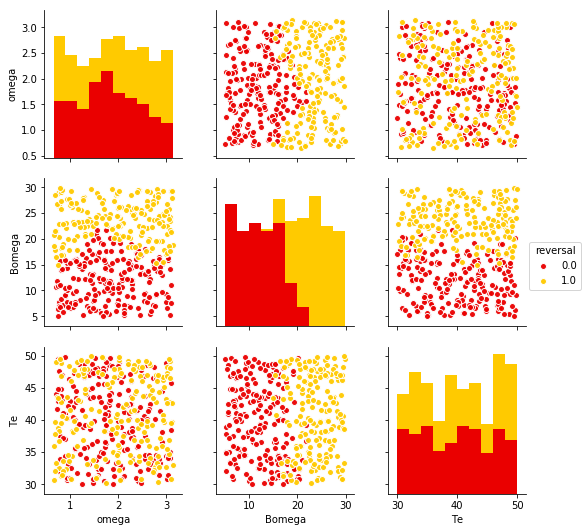

In [25]:
plt.figure(figsize=(18,12))
sns.pairplot(all_data, vars=["omega","Bomega","Te"], hue='reversal', palette='hot', plot_kws={'alpha':.95})
plt.savefig("high_dimension.png",dpi=300)

In [ ]:
#help(LogisticRegression)
# Create the hyperparameter grid
c_space = np.linspace(3, 4, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

In [ ]:
# fitting logistic Regression to the training set
log_reg = LogisticRegression(random_state=0)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log_reg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

In [ ]:
log_reg = LogisticRegression(random_state=0, penalty='l1', C=3.)
log_reg.fit(X_train, y_train)

In [ ]:
# predict the test set results
y_pred = log_reg.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,log_reg,sc_X,'Logistic Regression')
plt.savefig("figure3.png",dpi=300)

In [ ]:
# Analysis
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob)

In [ ]:
#help(KNeighborsClassifier)

In [ ]:
param_grid = {'n_neighbors': np.arange(1, 50),
              'p': np.arange(1,5)} # grid dictionary
knn_class = KNeighborsClassifier(metric='minkowski')
knn_cv = GridSearchCV(knn_class, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
# Print the optimal parameters and best score
print("Tuned K-Nearest Neighbors Parameter: {}".format(knn_cv.best_params_))
print("Tuned K-Nearest Neighbors Accuracy: {}".format(knn_cv.best_score_))

In [ ]:
## K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1) # euclidian distances
knn.fit(X_train,y_train)
# predict the test set results
y_pred = knn.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,knn,sc_X,'KNN')
plt.savefig("figure4.png",dpi=300)

In [ ]:
# Analysis
y_pred_prob = knn.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob)

In [ ]:
#help(SVC)

In [ ]:
param_grid = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'degree': np.arange(1,5),
              'gamma': np.logspace(-7,-5,10)}
scv_class = SVC(random_state=0, probability=True)
cv = GridSearchCV(scv_class, param_grid, cv=5)
cv.fit(X_train, y_train)
# Print the optimal parameters and best score
print("Tuned SVM Parameter: {}".format(cv.best_params_))
print("Tuned SVM Accuracy: {}".format(cv.best_score_))

In [ ]:
# fit SVM to the data
svc_class = SVC(kernel='linear', random_state=0, probability=True, gamma=1.e-7) ## kernels: 'linear, 'rbf'
svc_class.fit(X_train,y_train)

# predict the test set results
y_pred = svc_class.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,svc_class,sc_X,'SVM')
plt.savefig("figure5.png",dpi=300)

In [ ]:
# Analysis
y_pred_prob = svc_class.predict_proba(X_test)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_prob)

In [ ]:
#help(GaussianNB)

In [ ]:
# Fit Naive Bayes to the data
naive_B = GaussianNB()
naive_B.fit(X_train,y_train)

# predict the test set results
y_pred = naive_B.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,naive_B,sc_X,'Naive Bayes')
plt.savefig("figure6.png",dpi=300)
print("SVM Accuracy: {}".format(accuracy_score(y_test, y_pred, normalize=True)))

In [ ]:
# SVM Analysis
y_pred_prob = naive_B.predict_proba(X_test)[:,1]
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_prob)

In [ ]:
#help(RandomForestClassifier)

In [ ]:
param_grid = {"max_depth": [3, 4, 5, None],
              "n_estimators": np.arange(10,110,10),
              "criterion": ["gini", "entropy"]}
ran_forrest = RandomForestClassifier(random_state=0)
cv = GridSearchCV(ran_forrest, param_grid, cv=5)

cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned SVM Parameter: {}".format(cv.best_params_))
print("Tuned SVM Accuracy: {}".format(cv.best_score_))

In [ ]:
# Fit Random Forest to the training data
ran_forrest = RandomForestClassifier(n_estimators=60, criterion='entropy', max_depth=5, random_state=0)
ran_forrest.fit(X_train,y_train)

# predict the test set results
y_pred = ran_forrest.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,ran_forrest,sc_X,'Random Forest')
plt.savefig("figure7.png",dpi=300)

In [ ]:
# Analysis
y_pred_prob = ran_forrest.predict_proba(X_test)[:,1]
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_pred_prob)

In [ ]:
plt.figure(figsize=(14,9))
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr1, tpr1, 'r',  label='Logistic',lw=3)
plt.plot(fpr2, tpr2, 'b--',label='KNN',lw=3)
plt.plot(fpr3, tpr3, 'g',label='SVM',lw=6)
plt.plot(fpr4, tpr4, 'k--',label='Naive Bayes',lw=3)
plt.plot(fpr5, tpr5, color='magenta',label='Random Forest',lw=3)
plt.xlabel('False Positive Rate',fontsize=28)
plt.ylabel('True Positive Rate',fontsize=28)
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("figure8.png",dpi=300)

It looks like the best performing classifiears are Logistic, SVM, and Random Forest. What we will do next is create a voting classifier.

In [ ]:
voting_class = VotingClassifier(estimators=[('lr',log_reg), ('rf', ran_forrest), ('svc', svc_class)], voting='soft')
voting_class.fit(X_train,y_train)

# predict the test set results
y_pred = voting_class.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,voting_class,sc_X,'Voting Classification')
plt.savefig("figure9.png",dpi=300)

In [ ]:
# Analysis
y_pred_prob = voting_class.predict_proba(X_test)[:,1]
fpr6, tpr6, thresholds6 = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(14,9))
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr1, tpr1, 'r',  label='Logistic',lw=3)
plt.plot(fpr2, tpr2, 'b--',label='KNN',lw=3)
plt.plot(fpr3, tpr3, 'g',label='SVM',lw=6)
plt.plot(fpr4, tpr4, 'k--',label='Naive Bayes',lw=3)
plt.plot(fpr5, tpr5, color='magenta',label='Random Forest',lw=3)
plt.plot(fpr6, tpr6, 'c',  label='Voting',lw=3)
plt.xlabel('False Positive Rate',fontsize=28)
plt.ylabel('True Positive Rate',fontsize=28)
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("figure10.png",dpi=300)

## Trying some boosting techniques.

In [ ]:
#help(AdaBoostClassifier)

In [ ]:
ada_class = AdaBoostClassifier(SVC(kernel='linear', random_state=0, probability=True, gamma=0.0001), 
                               n_estimators=200,algorithm='SAMME.R', learning_rate=0.5)

ada_class.fit(X_train,y_train)

# predict the test set results
y_pred = voting_class.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,ada_class,sc_X,'Ada Boosting')
plt.savefig("figure11.png",dpi=300)

In [ ]:
#help(GradientBoostingClassifier)

In [ ]:
param_grid = {"max_depth": [2, 3, 4, 5, None],
              "n_estimators": np.arange(10,110,10),
              "learning_rate": np.arange(0.1,1.,0.1),
              "criterion": ["friedman_mse", "mse", "mae"]}
grad_boost = GradientBoostingClassifier(random_state=0)
cv = GridSearchCV(grad_boost, param_grid, cv=5)

cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned SVM Parameter: {}".format(cv.best_params_))
print("Tuned SVM Accuracy: {}".format(cv.best_score_))

In [ ]:
grad_boost = GradientBoostingClassifier(max_depth=2, n_estimators=40, learning_rate=0.1)
grad_boost.fit(X_train,y_train)

# predict the test set results
y_pred = grad_boost.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,grad_boost,sc_X,'Gradient Boosting')
plt.savefig("figure12.png",dpi=300)